### Import librerie ed oggetti

* pandas, per la manipolazione dei dati csv.
* seaborn (https://www.kaggle.com/learn/data-visualization) e matplotlib, per i grafici
* da sklearn:
    * LabelEncoder, per gestire variabili categoriali
    * DecisionTreeClassifier
    * RandomForestClassifier (da Kaggle)
    * LogisticRegression
    * MLPClassifier

In [1]:
!sudo apt update && sudo apt install -y graphviz

/bin/bash: sudo: command not found


In [2]:
!pip3 install graphviz
!pip3 install mglearn
!pip3 install seaborn
!pip3 install scikit-learn=='0.24.1'

### Import librerie necessarie

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import classification_report

### Importo i file di training e di test

In [4]:
customer_train = pd.read_csv('train.csv', error_bad_lines=False,dtype=str)
customer_test = pd.read_csv('test.csv', error_bad_lines=False,dtype=str)

### Preprocessing dei dati

Prepariamo i dati: 
* per prima cosa visualizziamo i dati di training
* rimuoviamo i duplicati
* rimuoviamo i valori nulli
* Effettuo l'encoding delle stringhe in interi.
* Cerco le feature più significative.
* Elimino le feature che hanno meno influenza sul risultato.

In [5]:
# visualizzo i dati di training 
customer_train

,Exited,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,0,7956,15644297,Austin,732,Germany,Male,38,5,178787.54,1,1,1,195760.53
1,0,6092,15777896,Chukwudi,850,Germany,Female,33,2,83415.04,1,0,1,74917.64
2,0,6522,15748231,Hargreaves,700,Germany,Male,35,4,95853.39,2,1,0,192933.37
3,0,3447,15764654,Zikoranachidimma,649,France,Male,37,9,87374.88,2,1,1,247.36
4,0,8039,15756824,Giordano,613,Germany,Female,50,5,101242.98,2,1,0,12493.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6395,0,7576,15687634,Glover,561,Germany,Male,49,5,94754.0,1,1,1,26691.31
6396,0,2876,15641640,Uspenskaya,545,Spain,Female,33,7,173331.52,1,1,0,150452.88
6397,0,2468,15716518,Yuryeva,617,France,Female,27,4,0.0,2,0,0,190269.21
6398,0,642,15580684,Feng,706,France,Female,29,5,112564.62,1,1,0,42334.38


Elenco delle informazioni contenute nel dataset: 
* CustomerId: id cliente
* Surname: cognome del cliente
* CreditScore: score creditizio
* Geography: paese d'appartenenza
* Gender: sesso
* Age: età
* Tenure: da quanto è cliente
* Balance: ammontare del conto in banca
* NumOfProducts: quanti prodotti finanziari usa
* HasCrCard: ha una carta di credito
* IsActiveMember: se il conto è attivo        
* EstimatedSalary: entrate stimate del cliente
* Exited: se ha cambiato banca o no

In [6]:
#trasformo in float e int i campi per facilitare i calcoli 
customer_train['Balance'] = customer_train.Balance.astype(float)
customer_train['Age'] = customer_train.Age.astype(int)
customer_train['Exited'] = customer_train.Exited.astype(int)
customer_train['CreditScore'] = customer_train.CreditScore.astype(int)
customer_train['Tenure'] = customer_train.Tenure.astype(int)
customer_train['NumOfProducts'] = customer_train.NumOfProducts.astype(int)
customer_train['HasCrCard'] = customer_train.HasCrCard.astype(int)
customer_train['IsActiveMember'] = customer_train.IsActiveMember.astype(int)
customer_train['EstimatedSalary'] = customer_train.EstimatedSalary.astype(float)

customer_test['Balance'] = customer_test.Balance.astype(float)
customer_test['NumOfProducts'] = customer_test.NumOfProducts.astype(int)

Introduco una nuova colonna: BalanceProduct. Questa colonna parte dal presupposto che un cliente della banca sarà più propenso a restare nel momento in cui utilizza un maggior numero di prodotti finanziari, ed anche sulla base del suo conto bancario. 

<AxesSubplot:xlabel='Exited', ylabel='BalanceProducts'>

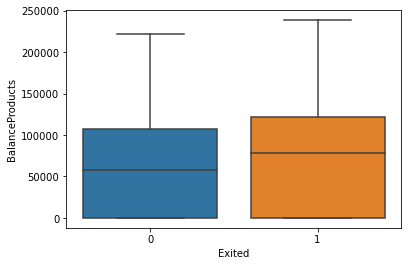

In [7]:
customer_train['BalanceProducts']=customer_train['Balance']/customer_train['NumOfProducts']
customer_test['BalanceProducts']=customer_test['Balance']/customer_test['NumOfProducts']

sns.boxplot(y='BalanceProducts',x = 'Exited',data = customer_train)

In [8]:
#controllo che non ci siano duplicati
customer_train.drop_duplicates(inplace=True)
customer_test.drop_duplicates(inplace=True)

In [9]:
#controllo che non ci siano valori nulli 
customer_train.isnull().any()
customer_test.isnull().any()
#non ce ne sono! 

Exited             False
RowNumber          False
CustomerId         False
Surname            False
CreditScore        False
Geography          False
Gender             False
Age                False
Tenure             False
Balance            False
NumOfProducts      False
HasCrCard          False
IsActiveMember     False
EstimatedSalary    False
BalanceProducts    False
dtype: bool

In [10]:
#Elimino subito alcuni attributi specifici per il cliente, che non mi servono.
customer_train = customer_train.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)
customer_test = customer_test.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)

In [11]:
customer_train

,Exited,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,BalanceProducts
0,0,732,Germany,Male,38,5,178787.54,1,1,1,195760.53,178787.540
1,0,850,Germany,Female,33,2,83415.04,1,0,1,74917.64,83415.040
2,0,700,Germany,Male,35,4,95853.39,2,1,0,192933.37,47926.695
3,0,649,France,Male,37,9,87374.88,2,1,1,247.36,43687.440
4,0,613,Germany,Female,50,5,101242.98,2,1,0,12493.61,50621.490
...,...,...,...,...,...,...,...,...,...,...,...,...
6395,0,561,Germany,Male,49,5,94754.00,1,1,1,26691.31,94754.000
6396,0,545,Spain,Female,33,7,173331.52,1,1,0,150452.88,173331.520
6397,0,617,France,Female,27,4,0.00,2,0,0,190269.21,0.000
6398,0,706,France,Female,29,5,112564.62,1,1,0,42334.38,112564.620


In [12]:
n = customer_train[customer_train.Exited=='1'].shape[0]

print(n*100/6400)
#Circa il 20% dei clienti è uscito.

0.0


In [13]:
#Effettua l'encoding delle stringhe in interi
label_encoder = LabelEncoder()
customer_train_encoded = customer_train.apply(label_encoder.fit_transform)
customer_test_encoded = customer_test.apply(label_encoder.fit_transform)

In [14]:
#visualizza la corrrelazione tra le features
print(customer_train_encoded.corr())

                   Exited  CreditScore  Geography    Gender       Age  \
Exited           1.000000    -0.032105   0.034386 -0.101447  0.270966   
CreditScore     -0.032105     1.000000   0.011443 -0.010541 -0.007271   
Geography        0.034386     0.011443   1.000000  0.009085  0.024511   
Gender          -0.101447    -0.010541   0.009085  1.000000 -0.019793   
Age              0.270966    -0.007271   0.024511 -0.019793  1.000000   
Tenure          -0.006723    -0.009664   0.001142  0.012088 -0.009973   
Balance          0.094707    -0.006948   0.049761  0.016859  0.022456   
NumOfProducts   -0.056231     0.017206   0.012576 -0.018031 -0.032639   
HasCrCard       -0.003878    -0.019218  -0.020191  0.007198 -0.016632   
IsActiveMember  -0.157399     0.029045   0.014888  0.018098  0.094186   
EstimatedSalary  0.017594     0.000620  -0.004515 -0.023769  0.002374   
BalanceProducts  0.096858    -0.010345   0.026748  0.020298  0.029528   

                   Tenure   Balance  NumOfProducts

POSITIVO:
* Geography: 0.040277
* Age: 0.275838
* Balance: 0.056870


NEGATIVO: 
* CreditScore: -0.020684 
* Gender: -0.112848
* Tenure: -0.011740 
* NumOfProducts: -0.050760  
* HasCrCard: -0.014153      
* IsActiveMember: -0.152874        
* EstimatedSalary: -0.005995

[[84, 100.0], [56, 72.72727272727273], [52, 64.17910447761194], [54, 58.333333333333336], [55, 56.36363636363637], [51, 56.16438356164384], [50, 56.09756097560975], [60, 55.0], [63, 54.166666666666664], [53, 48.93617021276596], [48, 48.03921568627451], [49, 46.73913043478261], [65, 46.15384615384615], [59, 45.0], [57, 44.89795918367347], [47, 43.80165289256198], [46, 42.06896551724138], [58, 40.90909090909091], [62, 40.0], [68, 36.36363636363637], [45, 35.338345864661655], [61, 34.285714285714285], [64, 30.434782608695652], [44, 29.559748427672957], [43, 28.272251308900522], [42, 24.09090909090909], [40, 22.22222222222222], [71, 18.75], [41, 17.903930131004365], [39, 17.32851985559567], [69, 16.666666666666668], [37, 14.61038961038961], [38, 14.521452145214521], [66, 14.285714285714286], [18, 14.285714285714286], [22, 13.72549019607843], [67, 13.636363636363637], [35, 13.356164383561644], [24, 12.5], [73, 12.5], [36, 11.960132890365449], [33, 11.307420494699647], [27, 8.450704225352112

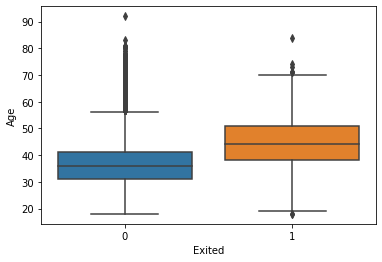

In [15]:
#Una delle features con valore più significativo è Age. Mi salvo i tipi di contratti, 
#e vedo se c'è qualche correlazione con il valore di Exited.

sns.boxplot(y='Age',x = 'Exited',data = customer_train)

tipi = customer_train['Age'].unique()
n_per_tipo = []
for tipo in tipi: 
    n_per_tipo.append([tipo, customer_train.Age.eq(tipo).sum(), customer_train[(customer_train.Age == tipo) & (customer_train.Exited == 1)].shape[0]])
#print(n_per_tipo)

def myFunc(e):
    return e[2]
n_per_tipo.sort(reverse=True, key=myFunc)

result=[]
for e in n_per_tipo: 
    result.append([e[0], (e[2]*100/e[1])])

def myFunc2(e):
    return e[1]

result.sort(reverse=True, key=myFunc2)
print(result)

# capiamo che (a parte quell'unico signore di 84 anni che ha deciso di cambiare banca e grazie al quale 
# la percentuale per quell'età risulta 100%), in percentuale sono le persone che vanno dai 68 ai 45 circa. 
# Le percenutali sono molto alte (sopra il 50%) tra 60 e 49 anni.

[['Germany', 1594, 0], ['France', 3180, 0], ['Spain', 1626, 0]]
[['Germany', 0.0], ['France', 0.0], ['Spain', 0.0]]


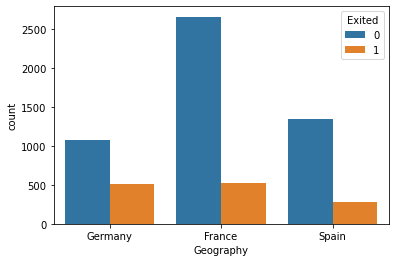

In [16]:
# Ora studiamo Geography, il paese di appartenenza.
sns.countplot(x='Geography', hue = 'Exited',data = customer_train)

tipi = customer_train['Geography'].unique()
n_per_tipo = []
for tipo in tipi: 
    n_per_tipo.append([tipo, customer_train.Geography.eq(tipo).sum(), customer_train[(customer_train.Geography == tipo) & (customer_train.Exited== '1')].shape[0]])
print(n_per_tipo)

result=[]
for e in n_per_tipo: 
    result.append([e[0], (e[2]*100/e[1])])

def myFunc2(e):
    return e[1]

result.sort(reverse=True, key=myFunc2)
print(result)

#Sembra che il 31% dei clienti tedeschi abbia deciso di abbandonare la banca! 
#In effetti sembra che il numero di clienti che abbandona la banca cresca al diminuire del numero totale dei clienti in quel paese.

In [17]:
# Ora analizziamo da Balance, l'ammontare del conto in banca.
n_per_cat = []
i = -1
categorie = [10, 100, 1000, 10000, 100000, 300000]
for cat in categorie: 
    appoggio = [cat, customer_train[customer_train['Balance'] < cat].shape[0], customer_train[(customer_train['Balance'] < cat) & (customer_train.Exited==1)].shape[0]]
    if i > 0:
        appoggio[1]=appoggio[1]-n_per_cat[i][1]
        appoggio[2]=appoggio[2]-n_per_cat[i][2]
    i+=1
    n_per_cat.append(appoggio)
print(n_per_cat)

result=[]
for e in n_per_cat: 
    result.append([e[0], (e[2]*100/e[1]) if e[2]!=0 else 0])

def myFunc2(e):
    return e[1]

result.sort(reverse=True, key=myFunc2)
print(result)
#Sembra che i clienti che se ne vanno sono quelli che sono nelle fasce di clienti che possiedono più denaro! 

[[10, 2342, 332], [100, 2342, 332], [1000, 0, 0], [10000, 2342, 332], [100000, 1040, 220], [300000, 5360, 1089]]
[[100000, 21.153846153846153], [300000, 20.317164179104477], [10, 14.17591801878736], [100, 14.17591801878736], [10000, 14.17591801878736], [1000, 0]]


<AxesSubplot:xlabel='Exited', ylabel='Tenure'>

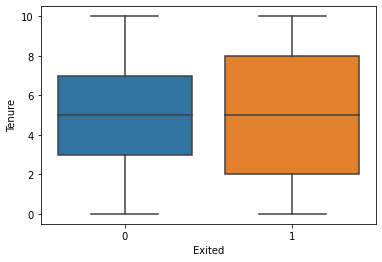

In [18]:
sns.boxplot(y='Tenure',x = 'Exited',data = customer_train)
#Sembra dal grafico che chi è diventato da poco cliente della banca o chi lo è da molto sia più propenso ad andar via.

Ci sono delle feature che non hanno impatto significativo sul dataset: per esempio Credit Score. 

<AxesSubplot:xlabel='Exited', ylabel='CreditScore'>

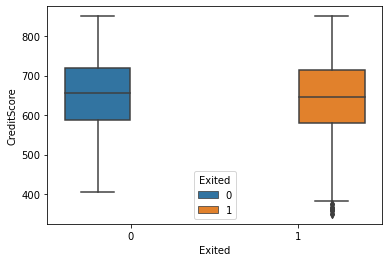

In [19]:
sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = customer_train)

In [20]:
#Notiamo che le feature che hanno minore impatto sul valore di Exited sono HasCrCard, 
#NumOfProducts, CreditScore. Le elimino.

customer_train_encoded.drop(['HasCrCard', 'NumOfProducts', 'CreditScore'], axis = 1, inplace = True)
customer_train.drop(['HasCrCard', 'NumOfProducts', 'CreditScore'], axis = 1, inplace = True)

customer_test_encoded.drop(['HasCrCard', 'NumOfProducts', 'CreditScore'], axis = 1, inplace = True)
customer_test.drop(['HasCrCard', 'NumOfProducts', 'CreditScore'], axis = 1, inplace = True)

### Split dei dati

In [21]:
#splitta i dati di train per avere feature (X_train) e target (y_train)
y_train = customer_train_encoded.pop('Exited')
X_train = customer_train_encoded

#splitta i dati di test per avere feature (X_test) e target (y_train)
y_test = customer_test_encoded.pop('Exited')
X_test = customer_test_encoded

In [23]:
#effettuo la classificazione con logistic regression 
log_reg = LogisticRegression(max_iter=350,n_jobs=-1, penalty='l2', random_state=None)
log_reg.fit(X_train, y_train)
print("Test set accuracy with Logistic Regression: {:.3f}".format(log_reg.score(X_test, y_test)))
print(classification_report(y_test, log_reg.predict(X_test.loc[:, X_test.columns != 'Exited'])))

Test set accuracy with Logistic Regression: 0.807
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      1265
           1       0.75      0.12      0.21       335

    accuracy                           0.81      1600
   macro avg       0.78      0.56      0.55      1600
weighted avg       0.80      0.81      0.75      1600



In [24]:
# effettuo la classificazione con random forest classifier 
rand_for = RandomForestClassifier(max_depth=8, n_estimators=50,random_state=0)
risultato = rand_for.fit(X_train, y_train)
print("Test set accuracy with Random Forest Classifier: {:.3f}".format(risultato.score(X_test, y_test)))
print(classification_report(y_test, rand_for.predict(X_test.loc[:, X_test.columns != 'Exited'])))

Test set accuracy with Random Forest Classifier: 0.838
              precision    recall  f1-score   support

           0       0.84      0.98      0.91      1265
           1       0.83      0.29      0.43       335

    accuracy                           0.84      1600
   macro avg       0.83      0.64      0.67      1600
weighted avg       0.84      0.84      0.81      1600



In [25]:
# effettuo la classificazione con KNN
knc = KNeighborsClassifier(n_neighbors = 10,n_jobs=-1)
risultato = knc.fit(X_train, y_train)
print("Test set accuracy with KNN: {:.3f}".format(risultato.score(X_test, y_test)))
print(classification_report(y_test, knc.predict(X_test.loc[:, X_test.columns != 'Exited'])))

Test set accuracy with KNN: 0.790
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1265
           1       0.00      0.00      0.00       335

    accuracy                           0.79      1600
   macro avg       0.40      0.50      0.44      1600
weighted avg       0.62      0.79      0.70      1600



In [29]:
mlp= MLPClassifier(random_state=1, max_iter=250, activation='tanh', alpha=1e-5)
mlp.fit(X_train, y_train)
print("Test set accuracy with MLP: {:.3f}".format(mlp.score(X_test, y_test)))
print(classification_report(y_test, mlp.predict(X_test.loc[:, X_test.columns != 'Exited'])))

Test set accuracy with MLP: 0.814
              precision    recall  f1-score   support

           0       0.81      1.00      0.89      1265
           1       0.95      0.12      0.21       335

    accuracy                           0.81      1600
   macro avg       0.88      0.56      0.55      1600
weighted avg       0.84      0.81      0.75      1600

